**Name:** Lukas Große Westermann  
**Exercise:** 2  
**Subject**: Computational Language Technologies

In the following the Wikipedia article of Albert einstein is scraped from wikipedia. This serves as input data, which is used to train our word2vec model.

# Setup

In [ ]:
!pip install wikipedia-api

In [ ]:
#Import of required modules
import wikipediaapi as wapi
import pandas as pd
from nltk.corpus import stopwords
import spacy
import numpy as np
from sklearn.manifold import TSNE
import gensim.downloader as api
from collections import Counter
import sys
import matplotlib.pyplot as plt 
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data

For the following task, the wikipedia api was used again. The Wikipedia article of Albert Einstein is downloaded and used for the following tasks.

In [ ]:
#Setting the language and the article
wiki = wapi.Wikipedia('en')
page_ab = wiki.page('Albert Einstein')

In [ ]:
#first test
text = [page_ab.text]
text[:100]

['Albert Einstein ( EYEN-styne; German: [ˈalbɛʁt ˈʔaɪnʃtaɪn] (listen); 14 March 1879 – 18 April 1955) was a German-born theoretical physicist, widely acknowledged to be one of the greatest physicists of all time. Einstein is best known for developing the theory of relativity, but he also made important contributions to the development of the theory of quantum mechanics. Relativity and quantum mechanics are together the two pillars of modern physics. His mass–energy equivalence formula E = mc2, which arises from relativity theory, has been dubbed "the world\'s most famous equation". His work is also known for its influence on the philosophy of science. He received the 1921 Nobel Prize in Physics "for his services to theoretical physics, and especially for his discovery of the law of the photoelectric effect", a pivotal step in the development of quantum theory. His intellectual achievements and originality resulted in "Einstein" becoming synonymous with "genius".In 1905, a year sometime

# Analysis

## Preprocessing & DataFrame

Before the word2vec model is fitted, the data is first prepared and cleaned.

In [ ]:
text = page_ab.text
text = text.split(" ")
#lower tokens and remove stop words for aplphabetic words
token = [w.lower() for w in text if w.isalpha()]
no_stops = [t for t in token if t not in stopwords.words('english')]

In [ ]:
#creation of the DataFrame with the original text and the cleaned text
df = pd.DataFrame({'Albert_Einstein_wiki':[text], 'Albert_Einstein_wiki_cleaned':[no_stops]})

In [ ]:
df

,Albert_Einstein_wiki,Albert_Einstein_wiki_cleaned
0,"[Albert, Einstein, (, EYEN-styne;, German:, [ˈ...","[albert, einstein, march, april, theoretical, ..."


### Lemmatization

The stop words have now been removed, but it is better to do the lemmatisation as well. This can increase the quality of the data.

In [ ]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.0 MB 5.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
#here, the necessary information is downloaded
nlp = spacy.load('en_core_web_sm') 

In [ ]:
doc = nlp(' '.join(df['Albert_Einstein_wiki_cleaned'].loc[0]))

In [ ]:
#the cleaned text will now be lemmatized 
lemmatized = []
for token in doc:
    lemmatized.append(token.lemma_)

In [ ]:
#add a new column for the data
df['Albert_Einstein_wiki_cleaned_lemmatized'] = [lemmatized]

Here is a short comparison of what lemmatization does to the data:

In [ ]:
df['Albert_Einstein_wiki_cleaned'][0][:10]

['albert',
 'einstein',
 'march',
 'april',
 'theoretical',
 'widely',
 'acknowledged',
 'one',
 'greatest',
 'physicists']

In [ ]:
df['Albert_Einstein_wiki_cleaned_lemmatized'][0][:10]

['albert',
 'einstein',
 'march',
 'april',
 'theoretical',
 'widely',
 'acknowledge',
 'one',
 'great',
 'physicist']

For instance, greatest is now great or acknowldged is now acknowledge. The input data is now cleaned and ready to use. This helps to improve the model. 

### Compare most common words

In [ ]:
#gives the most common words for the cleaned data 
Counter(df['Albert_Einstein_wiki_cleaned'].loc[0]).most_common(5)

[('einstein', 180),
 ('theory', 41),
 ('quantum', 32),
 ('also', 28),
 ('general', 27)]

In [ ]:
##gives the most common words for the cleaned and lemmatized data
Counter(df['Albert_Einstein_wiki_cleaned_lemmatized'].loc[0]).most_common(5)

[('einstein', 180),
 ('theory', 41),
 ('quantum', 32),
 ('become', 31),
 ('also', 28)]

One difference can directly be spotted, the word 'become' in the cleaned and lemmatized dataset is now in the top5 of the most frequent words. 

## Fit Word2Vec Model

In [ ]:
#Here the Word2Vec Model is fitted using the preprocessed data.

from gensim.models import Word2Vec

# here are the paratemeters set
feature_size = 100  # Word vector dimensionality
window_context = 5  # Context window size
min_word_count = 5  # Minimum word count

#the lemmatized data is used for the model
w2vmodel = Word2Vec(sentences=df['Albert_Einstein_wiki_cleaned_lemmatized'], size=feature_size, window=window_context, min_count=min_word_count, sg = 0)

## Most similiar words

In [ ]:
#shows the most similiar words to physics according to the trained data
w2vmodel.wv.most_similar('physics', topn=5)

[('einstein', 0.7450204491615295),
 ('quantum', 0.6932543516159058),
 ('would', 0.6809624433517456),
 ('energy', 0.6724427938461304),
 ('make', 0.6704082489013672)]

### Similiarities under the most common words

In [ ]:
#get the 3 most common words
most_common = dict(Counter(df['Albert_Einstein_wiki_cleaned_lemmatized'].loc[0]).most_common(3))

In [ ]:
#returns the most common items and the frequency
for key, value in most_common.items():
    print(key, value)

einstein 180
theory 41
quantum 32


In [ ]:
def similiarities(topN, model):  
  #get the most common words
  most_common = dict(Counter(df['Albert_Einstein_wiki_cleaned_lemmatized'].loc[0]).most_common(topN))

  #separate the keys from the values and put them into a list
  global keys
  keys = [key for key, value in most_common.items()]
  values = [value for key, value in most_common.items()]

  #returns the similiariy for each word to each word
  counter = 0
  for name1 in keys:
    print(name1+":")
    for name2 in keys:
      #the similiarity of the word to itself is always 1
      #therefore, it is skipped here
      if name1 == name2:
        continue
      else:
        #the fitted model is used here
        sim = model.wv.similarity(keys[counter], name2)
        print("\t * to "+ name2 +" \t: "+str(sim))
    counter += 1

similiarities(3, w2vmodel)

einstein:
	 * to theory 	: 0.8102441
	 * to quantum 	: 0.767151
theory:
	 * to einstein 	: 0.8102441
	 * to quantum 	: 0.7220715
quantum:
	 * to einstein 	: 0.767151
	 * to theory 	: 0.7220715


This shows the similarity according to our model of the topN (here 3) most used words.

### Similiar words to the most common words

In [ ]:
#returns similiar words to the most common words according to the model

def similiar_words(number_words, model): 
  similar_words = {
      search_term:
      [item[0] for item in model.wv.most_similar([search_term], topn=number_words)]
      for search_term in keys #keys was defined before, here Top 3
  }
  return similar_words

similiar_words(5, w2vmodel)

{'einstein': ['theory', 'use', 'result', 'quantum', 'light'],
 'quantum': ['einstein', 'light', 'become', 'theory', 'would'],
 'theory': ['einstein', 'use', 'also', 'would', 'quantum']}

The model itselft is not perfect, which can be seen with the similarity suggestions, because it returns that 'german' is similiar to 'quantum'. In our everyday language usage, we would not describe these words as particularly similar. The reason for that is, that the input data size is not perfect. It should be bigger and be more balanced. But this is the model according to the data.

## Visualization of embeddings

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


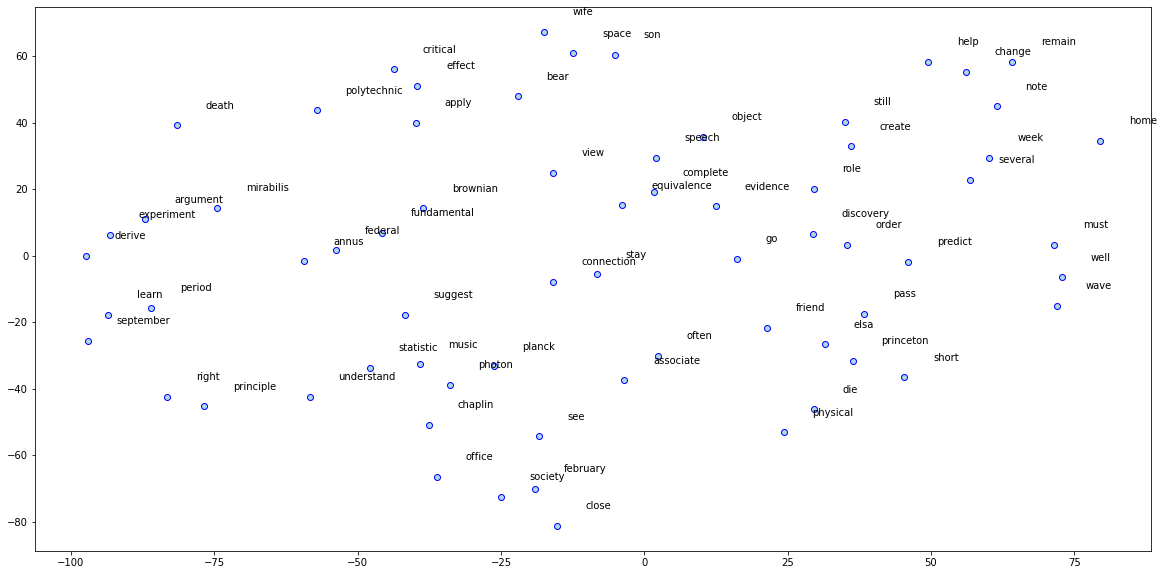

In [ ]:
# word sample of the vovabulary
words = w2vmodel.wv.index2word[140:350]  
# return embeddings from word forms    
wvs = w2vmodel.wv[words]                     

#creates a TSNE object
tsne = TSNE(n_components=2, random_state=0, n_iter=8000, perplexity=5) 
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

#creates the plot
plt.figure(figsize=(20, 10))
plt.scatter(T[:, 0], T[:, 1], c='lightblue', edgecolors='b')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 5, y + 5),
                 xytext=(0, 0),
                 textcoords='offset points')
plt.show()

Here it can also be visually confirmed that the model is not perfect, as some words are shown in close proximity which are not necessarily similar in reality.

# Comparison with a pretrained model

In [ ]:
# This downloads the pretrained Glove embeddings

glove_vectors = api.load("glove-wiki-gigaword-100")    

In [ ]:
w2vmodel.wv.most_similar('physics', topn=5)

[('einstein', 0.7450204491615295),
 ('quantum', 0.6932543516159058),
 ('would', 0.6809624433517456),
 ('energy', 0.6724427938461304),
 ('make', 0.6704082489013672)]

In [ ]:
glove_vectors.most_similar('physics', topn=5)

[('chemistry', 0.8498000502586365),
 ('mathematics', 0.834094762802124),
 ('science', 0.7914698719978333),
 ('biology', 0.7894973158836365),
 ('theoretical', 0.7342938780784607)]

Here, it can be seen that the pre-trained model performes better, because 'chemistry', 'mathematics', 'science', 'biology' and 'theoretical' sounds naturally more similiar to 'physics' than the other words 'einstein', 'theory', 'quantum', 'use' and 'new'. Also, the scores are better from the pre-trained model.

In [ ]:
#returns the similiarities from the topN most common words (here 3) according to the just trained word2vec model
similiarities(3, w2vmodel)

einstein:
	 * to theory 	: 0.8102441
	 * to quantum 	: 0.767151
theory:
	 * to einstein 	: 0.8102441
	 * to quantum 	: 0.7220715
quantum:
	 * to einstein 	: 0.767151
	 * to theory 	: 0.7220715


In [ ]:
#returns the similiarities from the topN most common words (here 3) according to the just downloaded pretrained glove_vectors model
similiarities(3, glove_vectors)

einstein:
	 * to theory 	: 0.6042599
	 * to quantum 	: 0.5993835
theory:
	 * to einstein 	: 0.6042599
	 * to quantum 	: 0.6607037
quantum:
	 * to einstein 	: 0.5993835
	 * to theory 	: 0.6607037


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


The scores from the pre-trained model are lower than from the word2vec model, this makes sense, because the pre-trained model does not indicate strong similiarities between the words. The scores for the word2vec model are higher, because of the limited input data.

In [ ]:
similiar_words(4, w2vmodel)

{'einstein': ['theory', 'use', 'result', 'quantum'],
 'quantum': ['einstein', 'light', 'become', 'theory'],
 'theory': ['einstein', 'use', 'also', 'would']}

In [ ]:
similiar_words(4, glove_vectors)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


{'einstein': ['relativity', 'freud', 'physics', 'bohr'],
 'quantum': ['electrodynamics', 'relativity', 'gravity', 'mathematical'],
 'theory': ['theories', 'concept', 'evolution', 'hypothesis']}

Here, the pre-trained model gives other similiar words to the most common words than the word2vec model. The glove_vector model connects 'einstein' with 'relativity' and 'physics' but also to other famous scientist like 'bohr' or 'freud'.  


To sum up the comparison, the generated model is not as good as the pre-trained model. The reason for that is the limited input data, as only one wikipedia article was used to generate this model. Furthermore, the word2vec model perform very bad for topics outside of this wikipedia article or it is simlpy not possible to run the code. For instance, the word2vec model is not capable to show similiar words to e.g. 'arts', because it is outside of the scope of this model. Therefore, the model has to be further trained to be able to compete with other pre-trained models. 

# Reflection

With this task a first Word2vec model could be fitted. The model was trained with the help of a Wikipedia article from Albert Einstein, which also showed that the input data is also decisive for how good the model is. Compared to an already trained model, the model generated here is not as good. The reasons for this have already been mentioned above.  

It was also exciting to turn linguistic sentences into vectors and then to work with them. I learned that word similarities can also be calculated and represented mathematically.